# Project 2
# *Histopathologic Cancer Detection*
# Problem Statement
Identify metastatic tissue in histopathologic scans of lymph node sections.
# Description
This is a binary classification problem. The main aim is to identify the presence of metastatic cancer from 96 x 96px digital histopathology images. The histopathological images are glass slide microscope images of lymph nodes that are stained with Hematoxylin and Eosin. Lymph nodes are small glands that filter the fluid in the lymphatic system and they are the first place a breast cancer is likely to spread. Histological assessment of lymph node metastases is part of determining the stage of breast cancer.
# Data overview
The dataset is a subset of the PCam dataset. The PCam dataset is derived from the Camelyon16 Challenge dataset. This dataset is a combination of two independent datasets collected in Radboud University Medical Center, and the University Medical Center Utrecht. We have been provided with approximately 220k training images and 57k testing images. A csv file with the name __train_labels.csv__ has been provided, which contains 2 columns, unique id corresponding to each training image and its label, i.e its classification category.
# Performance Metric
* Log Loss

# Objective and constraints
* No low-latency requirement.
* Errors can be very costly.

# Exploratory Data Analysis

In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
from random import shuffle
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, \
    Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Flatten
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    MaxPooling1D
from keras.layers.pooling import _GlobalPooling1D
from keras.losses import binary_crossentropy
from keras.models import Model
from keras.applications.nasnet import NASNetMobile, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from imgaug import augmenters as iaa
import imgaug as ia
print(os.listdir("../input"))

Using TensorFlow backend.


['train_labels.csv', 'train', 'sample_submission.csv', 'test']


__Reading the csv file train_labels.csv__

In [2]:
df_train = pd.read_csv("../input/train_labels.csv")
id_label_map = {k:v for k,v in zip(df_train.id.values, df_train.label.values)}
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


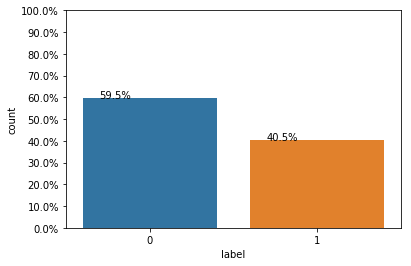

In [3]:
import seaborn as sns
total = len(df_train)*1.
ax=sns.countplot(x="label", data=df_train)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))

ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

**This plot shows that out off all training data, 59.5% belong to class 0, i.e. there is no metastatic tissue present.**

**And 40.5% belong to class 1, i.e. metastatic tissue is present and hence cancer is present.**

In [4]:
def get_id_from_file_path(file_path):
    return file_path.split(os.path.sep)[-1].replace('.tif', '')

In [5]:
train_files = glob('../input/train/*.tif')
test_files = glob('../input/test/*.tif')

In [6]:
print("Train_files size :", len(train_files))
print("Test_files size :", len(test_files))

Train_files size : 220025
Test_files size : 57458


**So in train_files we have total 220025 training images.**

**In test_files we have 57458 testing images.**

# Data Splitting
We are splitting training images into 2 sets : train and cross-validation(cv). Split train data to 90% training and 10% validation parts. 

In [7]:
train, cv = train_test_split(train_files, test_size=0.1, random_state=101010)

In [8]:
print('Number of data points in train data:', len(train))
print('Number of data points in cross validation data:', len(cv))

Number of data points in train data: 198022
Number of data points in cross validation data: 22003


**Now we have 198022 images for training set and 22003 images for cross validation set.**

# Data Augmentation

In [9]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
def get_seq():
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 90-110% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -10 to +10 percent (per axis)
                rotate=(-10, 10), # rotate by -10 to +10 degrees
                shear=(-5, 5), # shear by -5 to +5 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes
            )),
            
            iaa.SomeOf((0, 5), #Execute 0 to 5 of the following augmenters per image
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), 
                    # convert images into their superpixel representation sample between 20-200 superpixel per img
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 1.0
                        iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 3*3 and 5*5
                        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 3*3 and 5*5
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    # 0-No sharpning & 1-Full sharpning
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 1-5% of the pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2), #remove 1-2% of total size
                    ]),
                    iaa.Invert(0.01, per_channel=True), # invert color channels with 1% probability
                    iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -2 to 2 of original value)
                    iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5), #change brightness by 90-110%
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            second=iaa.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True
    )
    return seq

def data_gen(list_files, id_label_map, batch_size, augment=False):
    seq = get_seq()
    while True:
        shuffle(list_files)
        for batch in chunker(list_files, batch_size):
            X = [cv2.imread(x) for x in batch]
            Y = [id_label_map[get_id_from_file_path(x)] for x in batch]
            if augment:
                X = seq.augment_images(X)
            X = [preprocess_input(x) for x in X]
                
            yield np.array(X), np.array(Y)
    

# ML Model
**CNN : Using NASNETMobile as the base model which has been trained on ImageNet dataset.**

In [10]:
def get_model_classif_nasnet():
    inputs = Input((96, 96, 3))
    base_model = NASNetMobile(include_top=False, input_shape=(96, 96, 3))#, weights=None
    x = base_model(inputs)
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    out = Concatenate(axis=-1)([out1, out2, out3])
    out = Dropout(0.5)(out)
    out = Dense(1, activation="sigmoid", name="3_")(out)
    model = Model(inputs, out)
    model.compile(optimizer=Adam(0.0001), loss=binary_crossentropy, metrics=['acc'])
    model.summary()

    return model

In [11]:
model = get_model_classif_nasnet()

19996672/19993432 [==============================] - 0s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
NASNet (Model)                  (None, 3, 3, 1056)   4269716     input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 1056)         0           NASNet[1][0]                     
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1056)         0           NASNet[1][0]                     
____________________________________________

In [12]:
batch_size=32
h5_path = "model.h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit_generator(
    data_gen(train, id_label_map, batch_size, augment=True),
    validation_data=data_gen(cv, id_label_map, batch_size),
    epochs=2, verbose=1,
    callbacks=[checkpoint],
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(cv) // batch_size)

model.load_weights(h5_path)

Epoch 1/2


/opt/conda/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
/opt/conda/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_y = grid_y[slices]
/opt/conda/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:157: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the fu

6188/6188 [==============================] - 3331s 538ms/step - loss: 0.4210 - acc: 0.8083 - val_loss: 0.2191 - val_acc: 0.9159

Epoch 00001: val_acc improved from -inf to 0.91589, saving model to model.h5
Epoch 2/2
6188/6188 [==============================] - 3112s 503ms/step - loss: 0.3059 - acc: 0.8687 - val_loss: 0.2515 - val_acc: 0.8933

Epoch 00002: val_acc did not improve from 0.91589


In [21]:
print(history.history.keys())
print(history.history['val_loss'])
print(history.history['loss'])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
[0.2190664367264969, 0.2514593099052723]
[0.4210180303535792, 0.305931453240105]


In [15]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

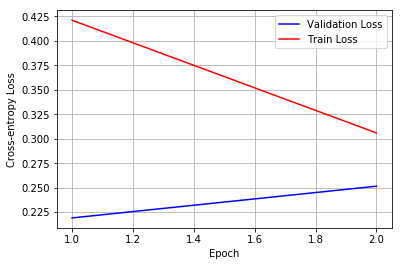

In [18]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy Loss')
nb_epoch = 2

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in history.history we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [22]:
preds = []
ids = []

In [23]:
for batch in chunker(test_files, batch_size):
    X = [preprocess_input(cv2.imread(x)) for x in batch]
    ids_batch = [get_id_from_file_path(x) for x in batch]
    X = np.array(X)
    preds_batch = ((model.predict(X).ravel()*model.predict(X[:, ::-1, :, :]).ravel()*model.predict(X[:, ::-1, ::-1, :]).ravel()*model.predict(X[:, :, ::-1, :]).ravel())**0.25).tolist()
    preds += preds_batch
    ids += ids_batch

In [24]:
df = pd.DataFrame({'id':ids, 'label':preds})
df.to_csv("baseline_nasnet.csv", index=False)
df.head()

,id,label
0,eb9e445089aed6402ef64ab0b416a31dfe73fae1,0.000109
1,2e7b0bdc8d15a47f26fb7db84d566f1e773fb708,0.995794
2,a1a9367e1a79f8e807019e2455d6be52d86c2678,0.004255
3,dbc6c9872643f51667bbdfe816c4c5e5b6238706,0.056325
4,a3395030af2286eff7bd94e5dc5a3ddbe5f9c591,0.883280


In [28]:
unique_genes = df['label'].value_counts()
print('Number of Unique probabilities :', unique_genes.shape[0])
# the top 10 probabilities that occured most
print(unique_genes.head(10))

Number of Unique probabilities : 57334
0.999395    3
0.985055    2
0.986532    2
0.999020    2
0.048833    2
0.998852    2
0.977790    2
0.999208    2
0.998021    2
0.990444    2
Name: label, dtype: int64


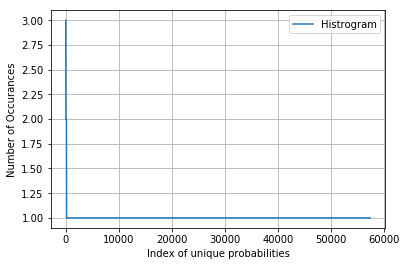

In [31]:
s = unique_genes.values
plt.plot(s, label="Histrogram")
plt.xlabel('Index of unique probabilities')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()